# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

## Performance Metrics

In the previous notebook, you learned about trade level analytics which help you evaluate your strategy after a trade has been executed. However, these metrics do not consider how the strategy performed within a trade. 

In this notebook, you will learn about some popular metrics which help you analyse in depth what happens between entry and exit time. The notebook is structured as follows:
1. [Read the Data](#read)
2. [Different Performance Measures](#perf)<br>
   2.1. [Equity Curve](#equi)<br>
   2.2. [CAGR](#cagr)<br>
   2.3. [Annualised Volatility](#vol)<br>
   2.4. [Sharpe Ratio](#sharpe)<br>
   2.5. [Maximum Drawdown](#mdd)<br>
   
## Import the Libraries 

In [1]:
# For data manipulation
import pandas as pd
import numpy as np
import datetime

# For plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

<a id='read'></a>
## Read the Data 

We have saved the AAPL price data and trade signals in the CSV file named `trading_signals.csv`. We will also need the trade details saved in `trades.csv`. You can read these files using the `pandas.read_csv()` method. 

In [2]:
# Read AAPL price data and trade signal
data = pd.read_csv('../data_modules/marubozu_trading_signals.csv',
                   parse_dates=['Date'], index_col='Date')

# Read the trade details
trades = pd.read_csv('../data_modules/marubozu_trades.csv', index_col=0)
trades.head()

,Entry_Date,Entry_Price,Exit_Date,Exit_Type,Exit_Price,PnL
0,2017-10-06,38.742500,2017-10-16,TP,39.970001,1.23
1,2018-01-11,43.647499,2018-01-12,TP,44.272499,0.62
2,2018-02-15,42.447498,2018-05-04,TP,45.957500,3.51
3,2018-05-11,47.372501,2018-06-25,SL,45.542500,-1.83
4,2018-09-25,54.937500,2018-09-27,TP,56.237499,1.30


<a id='perf'></a>
## Different Performance Measures

Before investing in a strategy you should have a clear understanding of its performance within trades. Just looking at the entry and exit values is not enough. You should also be able to answer questions like:<br>

<b>How much risk are you undertaking with this trading strategy?</b><br>
<b>How much drawdown should you expect with this strategy?</b><br>

Therefore, we have broken down some popular performance metrics to answer these questions. 

We will start by creating a dataframe `performance_metrics` to store all the values we calculate in this notebook. 

In [3]:
# Create a dataframe to store performance metrics
performance_metrics = pd.DataFrame(index=['Strategy'])

<a id='equi'></a>
### Equity Curve

An equity curve helps you visualise how the strategy returns have changed over a period of time. If the curve has a consistently positive slope, it indicates that the trading strategy is profitable. A negative slope shows that it is generating negative returns.

The equity curve also helps in visualising the drawdowns incurred within a strategy. 

To find the equity curve, we will first calculate the strategy's returns and then calculate the cumulative returns. Finally, we will plot the `Cumulative_Returns` column of our dataset.

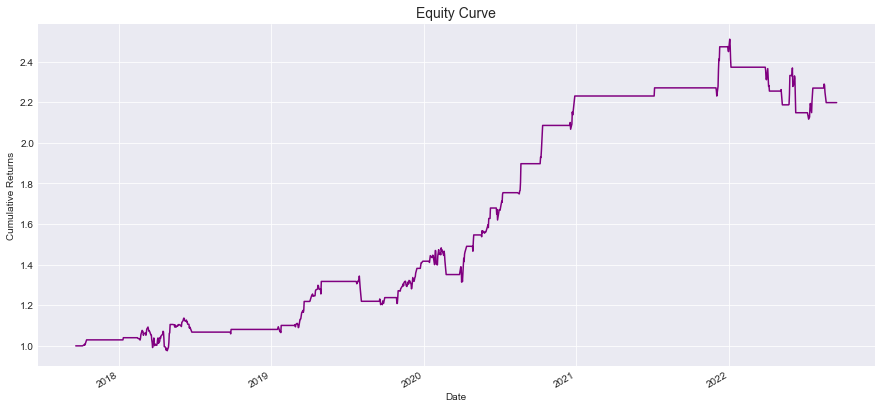

In [4]:
# Calculate strategy returns
data['Strategy_Returns'] = data.trade_signal.shift(1) * data.Close.pct_change()

# Calculate cumulative strategy returns
data['Cumulative_Returns'] = (data['Strategy_Returns'] + 1.0).cumprod()

# Plot the cumulative strategy returns
(data['Cumulative_Returns'].plot(figsize=(15, 7), color='purple'))
plt.title('Equity Curve', fontsize=14)
plt.ylabel('Cumulative Returns')
plt.show()

Overall, we can see the curve shows an increase in returns.  But through an equity curve, we can also analyse what happened within the trades. Let us take an example of a losing trade from our trade sheet. 

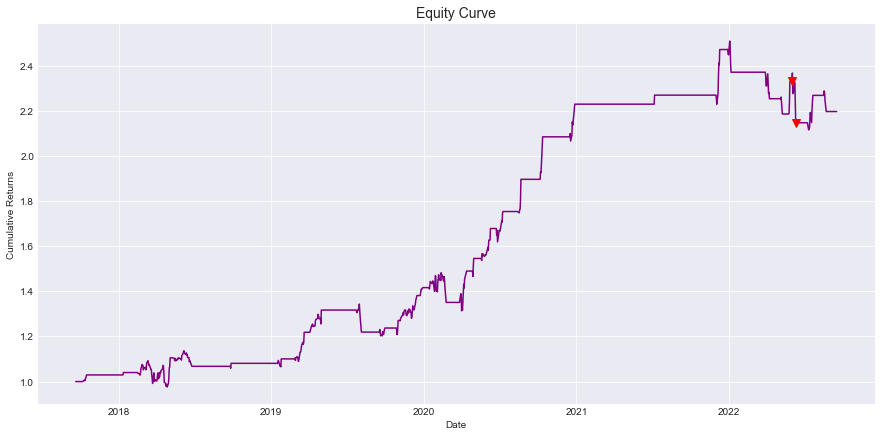

In [5]:
# Find entry and exit dates of largest loss
loss_entry = trades[trades.PnL == trades.PnL.min()]['Entry_Date'].values[0]
loss_exit = trades[trades.PnL == trades.PnL.min()]['Exit_Date'].values[0]

# Convert to datetime
loss_entry_date = datetime.datetime.strptime(loss_entry, '%Y-%m-%d')
loss_exit_date = datetime.datetime.strptime(loss_exit, '%Y-%m-%d')

# Plot the points on equity curve
plt.figure(figsize=(15, 7))
plt.plot(data['Cumulative_Returns'], color='purple')
plt.plot(loss_entry_date,
         data.loc[loss_entry_date].Cumulative_Returns, 'v', color='r', markersize=8)
plt.plot(loss_exit_date,
         data.loc[loss_exit_date].Cumulative_Returns, 'v', color='r', markersize=8)
plt.title('Equity Curve', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()

The entry and exit dates are shown by the two red markers in the above graph. With the equity curve, you can see that there was a small spike in this losing trade before its price fell again.

<a id='cagr'></a>
### CAGR
CAGR stands for compound annual growth rate. It is the measure of a strategy's annual growth rate over time, with the effect of compounding taken into account. It is calculated by the following formula: 

$$ CAGR = \left(\left(\frac{EV}{BV}\right)^{\frac{1}{n}} -1\right)*100 $$

where
* $EV$ is the ending value
* $BV$ is the beginning value
* $n$ is the number of years


In [6]:
# Total number of trading days
days = len(data['Cumulative_Returns'])

# Calculate compounded annual growth rate
performance_metrics['CAGR'] = "{0:.2f}%".format(
    (data.Cumulative_Returns.iloc[-1]**(252/days)-1)*100)

performance_metrics.T

,Strategy
CAGR,17.09%


We have got a CAGR of 17.09%. This means our initial capital grew annually by 17.09% with this strategy. 
<a id='hist'></a>
### Histogram of Returns
A histogram of returns is a chart that shows us the distribution of our strategy returns.

We will plot the histogram of `Strategy_Returns` returns using the `hist` method. 

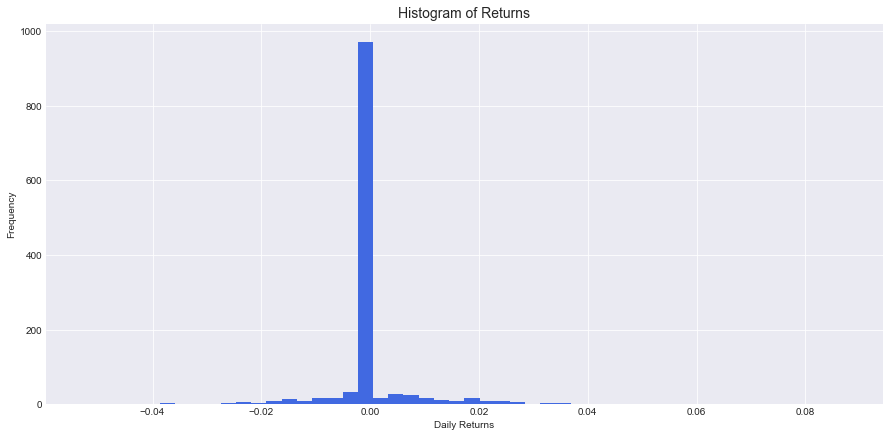

In [7]:
# Plot the histogram of returns
data.Strategy_Returns.hist(bins=50, figsize=(15, 7), color='royalblue')
plt.title('Histogram of Returns', fontsize=14)
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.show()

<a id='vol'></a>
### Annualised Volatility
Volatility is the rate at which the price of a security increases or decreases for a given set of returns over a period of time. 

We will calculate the annualised volatility by taking the standard deviation of the `strategy_ret`. To annualise them we will multiply it by the square root of 252. 

In [8]:
# Calculate annualised volatility
performance_metrics['Annualised Volatility'] = "{0:.2f}%".format(
    data['Strategy_Returns'].std()*np.sqrt(252) * 100)

performance_metrics.T

,Strategy
CAGR,17.09%
Annualised Volatility,14.01%


The strategy's annualised volatility works out to be 14.01%. This indicates that the returns for our strategy returns can fluctuate by 14.01% on an average in a year. 

<a id='sharpe'></a>
### Sharpe Ratio

Sharpe ratio measures the performance of a strategy when compared to a risk-free rate. It is the ratio of the returns earned in excess of the risk-free rate to the volatility. 
It is calculated as below:
$$ Sharpe~ratio = \frac{R_x-R_f}{\sigma_x}$$

where
* $R_x$ is the mean return of the strategy
* $R_f$ is the risk-free rate
* $\sigma_x$ is the volatility

Sharpe ratios greater than 1 are preferable, as it means your returns are greater given the risk you are taking. Generally, a strategy with a higher Sharpe ratio will be preferred over a strategy with a lower Sharpe ratio.

In [9]:
# Set a risk-free rate
risk_free_rate = 0.02/252

# Calculate Sharpe ratio
performance_metrics['Sharpe Ratio'] = np.sqrt(252)*(np.mean(data.Strategy_Returns) -
                                                    (risk_free_rate))/np.std(data.Strategy_Returns)

performance_metrics.T

,Strategy
CAGR,17.09%
Annualised Volatility,14.01%
Sharpe Ratio,1.054399


Here, our Sharpe ratio comes out to be 1.05, which means to gain 1.05 dollars you are risking 1 dollar. 
<a id='mdd'></a>
### Maximum Drawdown
Maximum drawdown is one of the key measures to assess the risk in a strategy.  In your trading strategy, your returns reduce in value multiple times. These reductions in value are known as drawdowns. The maximum of these drawdown values gives us an estimate of the maximum loss a strategy can incur. Technically, it is defined as the maximum loss from peak to trough for a portfolio.

It signifies the maximum loss from a peak to a trough of a strategy and is expressed in percentage terms. It can be calculated by the following formula: 

$$ Maximum ~Drawdown = \frac{Peak ~value - Trough ~value }{Peak ~value} $$

Generally, a lower magnitude of maximum drawdown is desired. 


In [10]:
# Compute the cumulative maximum
data['Peak'] = data['Cumulative_Returns'].cummax()

# Compute the Drawdown
data['Drawdown'] = ((data['Cumulative_Returns']-data['Peak'])/data['Peak'])

# Compute the maximum drawdown
performance_metrics['Maximum Drawdown'] =  "{0:.2f}%".format((data['Drawdown'].min())*100)
 
performance_metrics.T

,Strategy
CAGR,17.09%
Annualised Volatility,14.01%
Sharpe Ratio,1.054399
Maximum Drawdown,-15.69%


Thus, the maximum drawdown comes out to be -15.69%. This means you can expect to lose a maximum of around 15.69% when trading with this strategy. Let us also plot all the drawdowns to get an idea of how frequently they occur. 

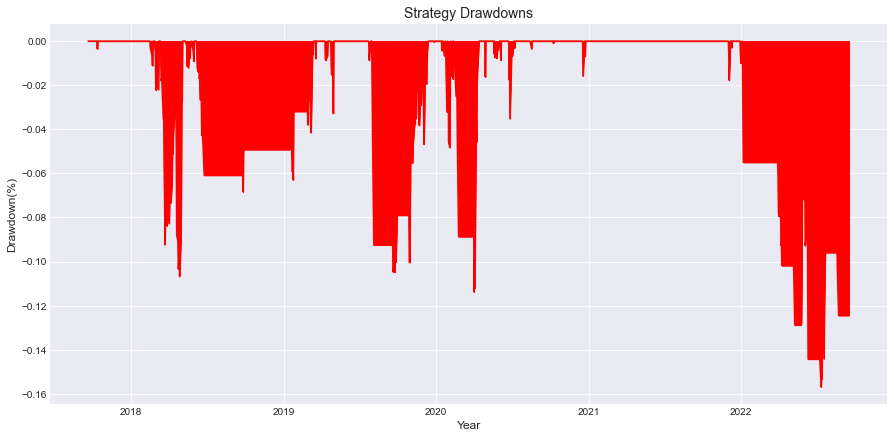

In [11]:
# Define size of graph
plt.figure(figsize=(15, 7))

# Set the title and axis labels
plt.title('Strategy Drawdowns', fontsize=14)
plt.ylabel('Drawdown(%)', fontsize=12)
plt.xlabel('Year', fontsize=12)

# Plot max drawdown
plt.plot(data['Drawdown'], color='red')

# Fill in-between the drawdown
plt.fill_between(data['Drawdown'].index, data['Drawdown'].values, color='red')
plt.show()

## Conclusion
In this notebook, we learned how to evaluate a strategy's performance in between the entry and exit times and also analyse the risk involved in undertaking these trades. 